## Depth integrated volume of water upwelled onto shelf per km

In [13]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [14]:
sns.set_context('paper')
sns.set_style('white')

In [15]:
# plotting functions
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')

In [16]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)

Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/ptracersGlob.nc' 
PtracersOutNoC = Dataset(PtracersNoC)

State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/stateGlob.nc' 

In [17]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 

drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')



times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [18]:
def HCW_Tracer_AlongShelf(Tr,MaskC,nzlim,rA,hFacC,drF,yin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : across-shore index of shelf break
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

In [19]:
Tr1 = rout.getField(Ptracers, 'Tr1')
Tr1NoC = rout.getField(PtracersNoC, 'Tr1')

In [20]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [30]:
ii=0
for rec in records:
    print(ii,rec.name)
    ii=ii+1
    
select_rec=[1,3,11,13]
labels = ['$10^{-5} $m$^2$s$^{-1}$',
          '$10^{-3} $m$^2$s$^{-1}$',
          '$10^{-3}$, $10^{-5} $m$^2$s$^{-1}$',
          '$10^{-3}$, $10^{-7} $m$^2$s$^{-1}$']
colors = ['0.4','k','k','k']
line_sty = ['-','-','--',':']

0 CNTDIFF_run43
1 CNTDIFF_run38
2 CNTDIFF_run37
3 CNTDIFF_run36
4 CNTDIFF_run45
5 CNTDIFF_run73
6 CNTDIFF_run75
7 CNTDIFF_run67
8 CNTDIFF_run51
9 CNTDIFF_run69
10 CNTDIFF_run71
11 3DVISC_run01
12 3DVISC_run02
13 3DVISC_run03
14 3DVISC_run04
15 LOW_BF_run01
16 LOWER_BF_run01


In [22]:
HCW,TrMass = HCW_Tracer_AlongShelf(Tr1,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

HCWNoC,TrMassNoc = HCW_Tracer_AlongShelf(Tr1NoC,mask_NoC,30,rA,hFacC,drF,227,30,180,50)

tracer limit concentration is:  7.39749
tracer limit concentration is:  7.39749


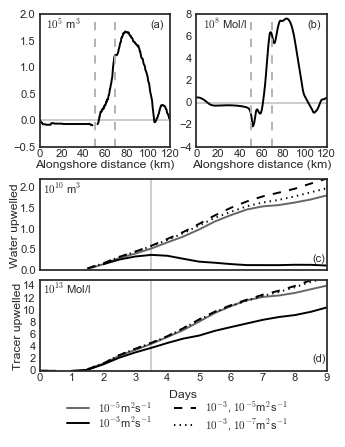

In [43]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (3.7,4.6)) # 95mm = 3.74in, 115cm = 4.52in

gs = gspec.GridSpec(2, 1, height_ratios=[0.9,1.3])
gs0 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0,0])
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0.1)

ax0 = plt.subplot(gs0[0,0])
ax1 = plt.subplot(gs0[0,1])
ax2 = plt.subplot(gs1[0,0],xticks=[])
ax3 = plt.subplot(gs1[1,0])

ii=7
jj = 0

ax0.axhline(0,color='0.8')
ax0.plot(xc[1,:]/1000,(HCW[ii,:]-HCWNoC[ii,:])/(100000*dxf[0,:]),sns.xkcd_rgb["black"])
ax0.text(0.85,0.9,'(a)',transform=ax0.transAxes)
ax0.text(0.05,0.9,'$10^5$ m$^3$',transform=ax0.transAxes)

ax1.axhline(0,color='0.8')
ax1.plot(xc[1,:]/1000,(TrMass[ii,:]-TrMassNoc[ii,:])/(100000000*dxf[0,:]),sns.xkcd_rgb["black"],)
ax1.text(0.85,0.9,'(b)',transform=ax1.transAxes)    
ax1.text(0.05,0.9,'$10^8$ Mol/l',transform=ax1.transAxes)    

ax2.axvline(3.5,color='0.8')
ax3.axvline(3.5,color='0.8')
for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
    
    ax2.plot(np.arange(19)/2.0,(dfcan['HCW']-dfnoc['HCW'])/1E10,line_sty[jj],color=colors[jj],label=labels[jj])
    ax3.plot(np.arange(19)/2.0,(dfcan['TrMass']-dfnoc['TrMass'])/1E13,line_sty[jj],color=colors[jj],label=labels[jj])
    jj=jj+1

ax2.text(0.95,0.1,'(c)',transform=ax2.transAxes)
ax3.text(0.95,0.1,'(d)',transform=ax3.transAxes)    

ax2.text(0.01,0.85,'$10^{10}$ m$^3$',transform=ax2.transAxes)
ax3.text(0.01,0.85,'$10^{13}$ Mol/l',transform=ax3.transAxes)    

#ax.axhline(0,color='0.3')
plotCanyonPos(ax0,xc[1,120]/1000,xc[1,240]/1000)
plotCanyonPos(ax1,xc[1,120]/1000,xc[1,240]/1000)

#ax0.set_ylabel('Water per m ($10^5$ m$^3$)',labelpad=-7)
ax0.set_xlabel('Alongshore distance (km)',labelpad=0.5)
ax1.set_xlabel('Alongshore distance (km)',labelpad=0.5)
#ax1.set_ylabel('Tracer per m ($10^8$ Mol/l)',labelpad=-6)
ax2.set_ylabel('Water upwelled',labelpad=0.0)
ax3.set_ylabel('Tracer upwelled',labelpad=0.2)
ax3.set_xlabel('Days')

ax2.set_ylim(0,2.2)

ax3.set_ylim(0,15)
ax3.legend(bbox_to_anchor=(0.9,-0.2),ncol=2,labelspacing=0.1)

ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax3.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax3.tick_params(axis='y', pad=3)

plt.savefig('fig_HCW_TrMass.eps',format='eps',bbox_inches='tight')
